# Transfer Learning with VGG16

In [49]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, models, transforms

In [50]:
!pip install torch_summary
from torchsummary import summary

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [52]:
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
import cv2, glob, numpy as np, pandas as pd
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [53]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

In [54]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

In [55]:
train_data_dir = 'training_set/training_set'
test_data_dir = 'test_set/test_set'

In [56]:
from random import shuffle, seed
seed(10)
class CatsDogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])
    shuffle(self.fpaths)
    self.targets =[fpath.split('/')[-1].startswith('dog')for fpath in self.fpaths]

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, idx):
    f = self.fpaths[idx]
    target = self.targets[idx]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    im = torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)

    return im.float().to(device), torch.tensor([target]).float().to(device)


In [57]:
data = CatsDogs(train_data_dir)

tensor([0.], device='cuda:0')


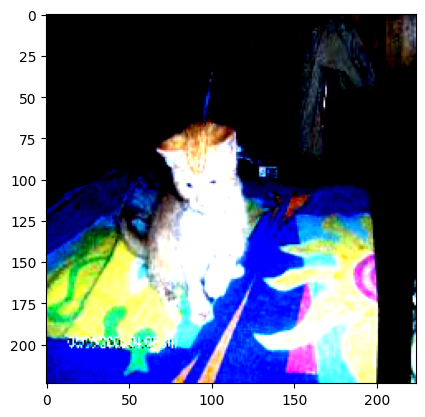

In [58]:
im, label = data[199]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)


In [68]:
def get_model():
  model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

  model.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 1),
      nn.Sigmoid()
  )

  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  return model.to(device), loss_fn, optimizer

In [69]:
model, criterion, optimizer = get_model()

In [70]:
summary(model.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [71]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()

  pred = model(x)
  batch_loss = loss_fn(pred, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()

  return batch_loss.item()

In [72]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()

  pred = model(x)
  is_correct = (pred > 0.5) == y

  return is_correct.cpu().numpy().tolist()

def get_data():
  train = CatsDogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

  val = CatsDogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)

  return trn_dl, val_dl

In [73]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [74]:
train_losses, train_accuracies = [], []
val_accuracies = []

for epoch in range(5):
  print(epoch)

  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)

  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)

    train_epoch_accuracies.extend(is_correct)

  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)

  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4


/tmp/ipython-input-2340188284.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \


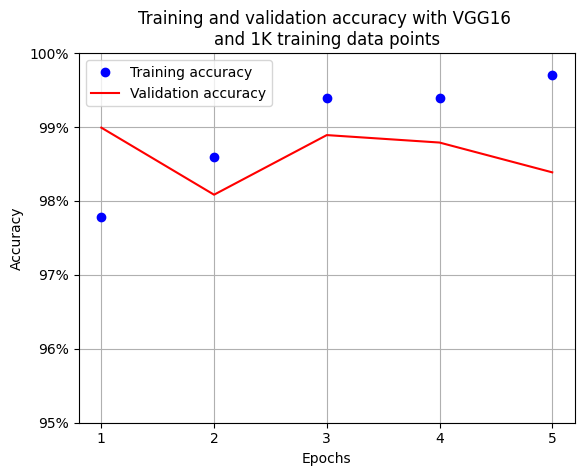

In [75]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo',
        label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r',
        label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy \
with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
                          for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()